# Creating Confidence Intervals for Machine Learning Classifiers

In [1]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -u -d -v -p numpy,mlxtend,matplotlib,sklearn

Author: Sebastian Raschka

Last updated: 2022-04-24

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 8.0.1

numpy     : 1.22.1
mlxtend   : 0.19.0
matplotlib: 3.5.1
sklearn   : 1.0.2



- This notebook provides an outline of different methods for creating confidence intervals for machine learning models. Note that these methods also apply to deep learning. 
- The text in this notebook is purposefully short so that we can focus on the technical execution without getting bogged down in details; there are many links to all the relevant conceptual explanations throughout this notebook.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Confidence Intervals in a Nutshell

- In a nutshell, what is a 95% confidence interval anyway? Imagine that you have a statistic (a measurement of some sort) that you calculated from a sample drawn from a population. Our goal is to estimate a population parameter with this statistic, for example, we could estimate the population mean with the sample mean. Most of the time, the estimated value and the true value are not the same, and we can use the confidence interval to quantify the uncertainty of that estimate.

- But how do we interpret confidence interval? A 95% confidence interval is essentially a method that computes an upper and lower bound around that estimate. The true parameter is either insider or outside these bounds. 



- In practice, this is not feasible, but let's assume for a moment that we had access to the population. If we drew a very large number of samples from the distribution and applied our confidence interval method to these samples, 95% of the confidence intervals would contain the true value.

- In a machine learning context, what we are usually interested in is the performance of our model. So, here the population parameter we want to estimate could be the generalization accuracy of our model. Then, the test set accuracy represents our estimated generalization accuracy. The 95% confidence interval gives us an uncertainty measure of how accurate this estimate is.

- As a side-note, we can say that the difference of two measurements is statistically significant if confidence intervals *do not* overlap. However we *cannot* say that results are *not* statistically significant if confidence intervals overlap. (The [Error bars](https://www.nature.com/articles/nmeth.2659) article in the Points of Significance series illustrates this nicely.) If we want to check whether the difference is not statistical significant, we would have to take a look at the distribution of the differences and check whether its confidence interval contains 0 or not. 



## Defining a Dataset and Model for Hands-on Examples

- We just use the [Iris dataset](https://archive.ics.uci.edu/ml/datasets/iris) and a [Decision tree classifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) for the sake of simplicity.


In [3]:
from mlxtend.data import iris_data
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

X, y = iris_data()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=123, stratify=y
)

clf = DecisionTreeClassifier(random_state=123)

## 1) Normal Approximation Interval Based on the Test Set

- This is maybe the easiest and classic way for creating confidence intervals.

- Using this method, we compute the confidence interval from a single training-test split. This is particularly attractive in deep learning where model training is expensive.

- It's also attractive (usually in a deep learning context) when we are interested in a very particular model (vs. models fit on different training folds like in k-fold cross-validation).

- You can find a description of these method i section *1.7 Confidence Intervals via Normal Approximation* of my "[Model Evaluation, Model Selection, and Algorithm Selection in Machine Learning](https://arxiv.org/abs/1811.12808)" article.

- In a nutshell, the equation for computing the confidence interval for an estimated parameter (let's say the the sample mean $\bar{x}$) assuming a normal distribution is computed as follows:

$$
\bar{x} \pm z \times \text{SE}
$$

- where
    - $z$ is the $z$ value (the number of standard deviations that a value lies from the mean of a standard normal distribution)
    - $SE$ is the standard error of the estimated parameter (here: sample mean
    
    
- In our case, the sample mean $\bar{x}$ is test set accuracy $\text{ACC}_{\text{test}}$, a proportion of success (in the context of a [Binomial proportion confidence interval](https://en.wikipedia.org/wiki/Binomial_proportion_confidence_interval)). 
- The standard error, under a normal approximation can be computed as 


$$
\text{SE} = \sqrt{ \frac{1}{n} \text{ACC}_{\text{test}}\left(1- \text{ACC}_{\text{test}}\right)},
$$

where $n$ is the test set size.

- So, plugging the SE back into the formula above, we get

$$
\text{ACC}_{\text{test}} \pm z \sqrt{\frac{1}{n} \text{ACC}_{\text{test}}\left(1- \text{ACC}_{\text{test}}\right)}.
$$




- Let's start with computing the z-value, which can obtain from `scipy.stats.norm.ppf` rather than looking it up from a $z$ table in one of our old statistics textbook.

In [4]:
import scipy.stats

confidence = 0.95  # Change to your desired confidence level
z_value = scipy.stats.norm.ppf((1 + confidence) / 2.0)
print(z_value)

1.959963984540054


- Next, let's compute the test accuracy of the classifier, and plug in the values into the formula above; the Python code for this is as follows:

In [5]:
import numpy as np

clf.fit(X_train, y_train)

acc_test = clf.score(X_test, y_test)
ci_length = z_value * np.sqrt((acc_test * (1 - acc_test)) / y_test.shape[0])

ci_lower = acc_test - ci_length
ci_upper = acc_test + ci_length

print(ci_lower, ci_upper)

0.873179017733963 1.0398644605269067


- Let's visualize the confidence interval using the following code:

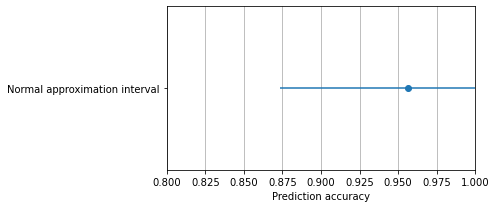

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(7, 3))

ax.errorbar(acc_test, 0, xerr=ci_length, fmt="o")

ax.set_xlim([0.8, 1.0])

ax.set_yticks(np.arange(1))
ax.set_yticklabels(["Normal approximation interval"])
ax.set_xlabel("Prediction accuracy")

plt.tight_layout()
plt.grid(axis="x")
plt.savefig("matplotlib-figures/normal-approx.pdf")
plt.show()

- Lastly, let's store our confidence interval in a Python dictionary so that we can retrieve it later when we compare it to other confidence intervals:

In [7]:
results = {
    "Method 1: Normal approximation": {
        "Test accuracy": acc_test,
        "Lower 95% CI": ci_lower,
        "Upper 95% CI": ci_upper,
    }
}

### 2) Bootstrapping Training Sets -- Setup Step

- Confidence intervals are used to estimate unknown parameters. If we only have one measurement, like the accuracy from a single test set, we need to make assumptions about the distribution that this accuracy values comes from. E.g., we can assume it's from a normal distribution. 

- In an ideal world, we have access to the distribution that this sample comes from, so that we can e.g., look at the range of values that 95% of the samples accuracy values fall into. This is desirable but not practical since we don't have an infinite pool of test sets.   

- Now, a workaround is bootstrapping, which estimates the sampling distribution. This is done by taking multiple samples with replacement from a single random sample.

- The method we are using here is also often referred to as out-of-bag bootstrap where we are training the model on training folds and evaluate it on held-out data points from each round. For more detail, please see section 2, *Bootstrapping and Uncertainties* of "[Model Evaluation, Model Selection, and Algorithm Selection in Machine Learning](https://arxiv.org/abs/1811.12808)."

- The equation is as follows:

$$
\text{ACC}_{\text{bootavg}}=\frac{1}{b} \sum_{j=1}^{b} \text{ACC}_{\text{boot}, j}
$$

- There are different flavors of bootstrapping. Below, we create multiple bootstrap samples for re-use in the upcoming sections.

- Note that a minimum of bootstrap rounds of 200 is the typical recommendation as per the "[Introduction to the Bootstrap](https://scholar.google.com/scholar_lookup?title=An%20introduction%20to%20the%20bootstrap&author=&publication_year=1993)" book. 

In [8]:
import numpy as np

rng = np.random.RandomState(seed=12345)
idx = np.arange(y_train.shape[0])

bootstrap_train_accuracies = []
bootstrap_rounds = 200


for i in range(bootstrap_rounds):

    train_idx = rng.choice(idx, size=idx.shape[0], replace=True)
    valid_idx = np.setdiff1d(idx, train_idx, assume_unique=False)

    boot_train_X, boot_train_y = X_train[train_idx], y_train[train_idx]
    boot_valid_X, boot_valid_y = X_train[valid_idx], y_train[valid_idx]

    clf.fit(boot_train_X, boot_train_y)
    acc = clf.score(boot_valid_X, boot_valid_y)
    bootstrap_train_accuracies.append(acc)

bootstrap_train_mean = np.mean(bootstrap_train_accuracies)
bootstrap_train_mean

0.9463377985233019

- We can visualize the test accuracies from bootstrapping ($ \text{ACC}_{\text{boot}, j}$) along with their sample mean ($\text{ACC}_{\text{bootavg}}$) in a historgram:

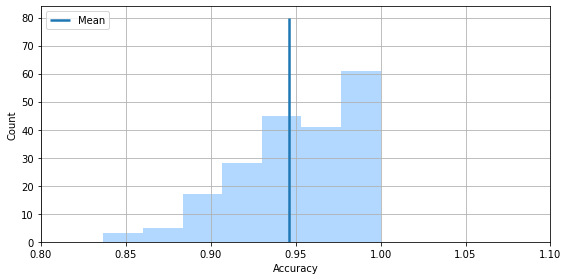

In [9]:
fig, ax = plt.subplots(figsize=(8, 4))

ax.vlines(bootstrap_train_mean, [0], 80, lw=2.5, linestyle="-", label="Mean")

ax.hist(
    bootstrap_train_accuracies, bins=7, color="#0080ff", edgecolor="none", alpha=0.3
)
plt.legend(loc="upper left")

plt.xlim([0.8, 1.1])

plt.xlabel('Accuracy')
plt.ylabel('Count')

plt.tight_layout()
plt.grid()
plt.savefig("matplotlib-figures/bootstrap-hist.pdf")
plt.show()

- Useful tidbit: Here, we are creating validation sets from the training set. However, if you don't tune your model on the training set, you could use the whole dataset for this since actually don't need a test set for evaluation then. Or in other words, the bootstrap methods can serve can take the place of a test set for model evaluation. This is particularly attractive for small datasets.

### 2.1) A *t* Confidence Interval Interval from Bootstrap Samples

- Assuming that the sample means are normal distributed we could compute the confidence interval formula as before, as follows:

$$
\text{ACC}_{\text{test}} \pm z \times \text{SE}.
$$

- But since we are dealing with a relatively small sample where we also estimate the population standard deviation via the sample standard deviation (this is used t calculate the standard error), we replace the $z$ value with a $t$ value from a t-distribution:

$$
\text{ACC}_{\text{test}} \pm t \times \text{SE}.
$$


- We can then compute the standard error (SE) by the as the standard deviation of this distribution:

$$
\text{SE}=\sqrt{\frac{1}{b-1} \sum_{j=1}^{b}\left(\text{ACC}_{\text{boot},j}-{\text{ACC}_\text{bootavg}}\right)^{2}}.
$$


- Note that we usually divide the standard deviation (SD) by $\sqrt{n}$ to obtain the standard error (SE) where $n = b$:

$$ \text{SE} = \frac{\text{SD}}{\sqrt{n}}.$$

- However, this is not necessary here since the bootstrap distribution is a distribution of means (as opposed to single data points), and $\text{ACC}_{\text{bootavg}}$ is the mean of these means.

- (As an optional exercise, you can try to modify the code below to include the division by $\sqrt{n}$ (where $\sqrt{n} = \sqrt{b}$), and you will probably find that this shrinks the confidence interval to an unrealistic degree, which also doesn't match the percentile method results anymore that we will introduce shortly.)


- Again, instead of using a t-table in our old statistics textbook, let's use SciPy to obtain the t-value for a 95% confidence interval and $b-1$ degrees of freedom:

In [10]:
confidence = 0.95  # Change to your desired confidence level
t_value = scipy.stats.t.ppf((1 + confidence) / 2.0, df=bootstrap_rounds - 1)
print(t_value)

1.971956544249395


In [11]:
se = 0.0
for acc in bootstrap_train_accuracies:
    se += (acc - bootstrap_train_mean) ** 2
se = np.sqrt((1.0 / (bootstrap_rounds - 1)) * se)

ci_length = t_value * se

ci_lower = bootstrap_train_mean - ci_length
ci_upper = bootstrap_train_mean + ci_length

print(ci_lower, ci_upper)

0.879470830164037 1.0132047668825668


- Now, let's add the CI to our histogram plot:

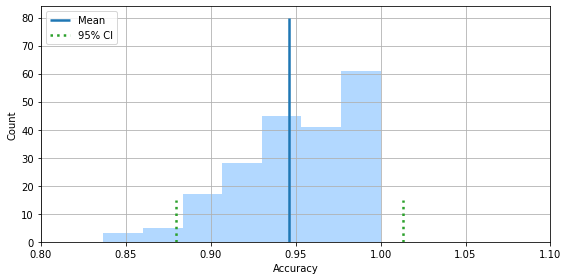

In [12]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.vlines(bootstrap_train_mean, [0], 80, lw=2.5, linestyle="-", label="Mean")

ax.vlines(ci_lower, [0], 15, lw=2.5, linestyle="dotted", label="95% CI", color="C2")
ax.vlines(ci_upper, [0], 15, lw=2.5, linestyle="dotted", color="C2")

ax.hist(
    bootstrap_train_accuracies, bins=7, color="#0080ff", edgecolor="none", alpha=0.3
)
plt.legend(loc="upper left")

plt.xlim([0.8, 1.1])
plt.xlabel('Accuracy')
plt.ylabel('Count')

plt.tight_layout()
plt.grid()
plt.savefig("matplotlib-figures/bootstrap-hist-oob-t.pdf")

plt.show()

- (We will compare the interval to the normal approximation interval in a later section.)
- Again, let's add our CI values to the Python dictionary for a comparison study later.

In [13]:
results["Method 2.1: Bootstrap, 1-sample CI"] = {
    "Test accuracy": bootstrap_train_mean,
    "Lower 95% CI": ci_lower,
    "Upper 95% CI": ci_upper,
}

### 2.2) Bootstrap Confidence Intervals Using the Percentile Method

- Now, while the approach outlined in the previous section seems pretty straightforward if our samples follow a normal distribution, there is a more robust and general approach for utilizing the bootstrap samples, namely, the percentile method (section 2, *Bootstrapping and Uncertainties* of my "[Model Evaluation, Model Selection, and Algorithm Selection in Machine Learning"](https://arxiv.org/abs/1811.12808) article).
- Here, we pick our lower and upper confidence bounds as follows:

  - $\text{ACC}_{lower} = \alpha_{1}th$ percentile of the $\text{ACC}_\text{boot}$ distribution
  - $\text{ACC}_{upper} = \alpha_{2}th$ percentile of the $\text{ACC}_{boot}$ distribution,

- Here, $\alpha_1 = \alpha$ and $\alpha_2 = 1 - \alpha$, and $\alpha$ is our degree of confidence to compute the $100 \times (1 - 2 \times \alpha)$ confidence interval. For instance, to compute a 95% confidence interval, we pick $\alpha = 0.025$ to obtain the 2.5th and 97.5th percentiles of the *b* bootstrap samples distribution as our upper and lower confidence bounds.

In [14]:
ci_lower = np.percentile(bootstrap_train_accuracies, 2.5)
ci_upper = np.percentile(bootstrap_train_accuracies, 97.5)

print(ci_lower, ci_upper)

0.8695652173913043 1.0


- Let's have a look how it looks like in the context of our 

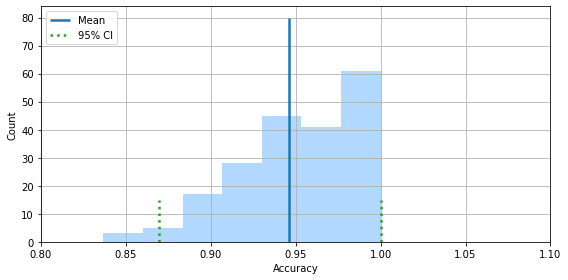

In [15]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.vlines(bootstrap_train_mean, [0], 80, lw=2.5, linestyle="-", label="Mean")

ax.vlines(ci_lower, [0], 15, lw=2.5, linestyle="dotted", label="95% CI", color="C2")
ax.vlines(ci_upper, [0], 15, lw=2.5, linestyle="dotted", color="C2")

ax.hist(
    bootstrap_train_accuracies, bins=7, color="#0080ff", edgecolor="none", alpha=0.3
)
plt.legend(loc="upper left")

plt.xlim([0.8, 1.1])
plt.xlabel('Accuracy')
plt.ylabel('Count')

plt.tight_layout()
plt.grid()
plt.savefig("matplotlib-figures/bootstrap-hist-oob-percentile.pdf")

plt.show()

In [16]:
results["Method 2.2: Bootstrap, percentile"] = {
    "Test accuracy": bootstrap_train_mean,
    "Lower 95% CI": ci_lower,
    "Upper 95% CI": ci_upper,
}

### 2.3) Reweighting the Boostrap Samples via the .632 Bootstrap

- Building on the previously introduced bootstrap percentile method, a slightly improved version is the [.632 Bootstrap](https://scholar.google.com/scholar?hl=en&as_sdt=0%2C50&q=Estimating+the+error+rate+of+a+prediction+rule%3A+improvement+on+cross-validation&btnG=).

- Skipping over the technical details the previously introduced bootstrap method has a small pessimistic bias, which means that it reports a test accuracy that is slightly worse than the true generalization accuracy of the model; the so-called .632 bootstrap aims to address that.

- For a more detailed discussion please see section 2, *Bootstrapping and Uncertainties* of my "[Model Evaluation, Model Selection, and Algorithm Selection in Machine Learning"](https://arxiv.org/abs/1811.12808) article).

- We are skipping the formulas and jump directly into the code implementation (in practice, I recommend using my implementation in [mlxtend](http://rasbt.github.io/mlxtend/user_guide/evaluate/bootstrap_point632_score/)).

- In a nutshell, you can think of it as a reweighted version of the bootstrap method we used earlier:

In [17]:
rng = np.random.RandomState(seed=12345)
idx = np.arange(y_train.shape[0])

bootstrap_train_accuracies = []
bootstrap_rounds = 200
weight = 0.632

for i in range(bootstrap_rounds):

    train_idx = rng.choice(idx, size=idx.shape[0], replace=True)
    valid_idx = np.setdiff1d(idx, train_idx, assume_unique=False)

    boot_train_X, boot_train_y = X_train[train_idx], y_train[train_idx]
    boot_valid_X, boot_valid_y = X_train[valid_idx], y_train[valid_idx]

    clf.fit(boot_train_X, boot_train_y)
    valid_acc = clf.score(boot_valid_X, boot_valid_y)
    # predict training accuracy on the whole training set
    # as ib the original .632 boostrap paper
    # in Eq (6.12) in
    #    "Estimating the Error Rate of a Prediction Rule: Improvement
    #     on Cross-Validation"
    #     by B. Efron, 1983, https://doi.org/10.2307/2288636
    train_acc = clf.score(X_train, y_train)

    acc = weight * train_acc + (1.0 - weight) * valid_acc

    bootstrap_train_accuracies.append(acc)

bootstrap_train_mean = np.mean(bootstrap_train_accuracies)
bootstrap_train_mean

0.9677367193053941

In [18]:
ci_lower = np.percentile(bootstrap_train_accuracies, 2.5)
ci_upper = np.percentile(bootstrap_train_accuracies, 97.5)

print(ci_lower, ci_upper)

0.9221417322834646 1.0


In [19]:
results["Method 2.3: Bootstrap, .632"] = {
    "Test accuracy": bootstrap_train_mean,
    "Lower 95% CI": ci_lower,
    "Upper 95% CI": ci_upper,
}

### 2.4) Taking the Reweighting One Step Further: The .632+ Bootstrap 

The [.632+ Bootstrap](https://scholar.google.com/scholar_lookup?&title=Improvements%20on%20Cross-Validation%3A%20The%20.632%2B%20Bootstrap%20Method&journal=J%20Am%20Stat%20Assoc&doi=10.1080%2F01621459.1997.10474007&volume=92&issue=438&pages=548-560&publication_year=1997&author=Efron%2CB&author=Tibshirani%2CR) is an improvement over the .632 Bootstrap we implemented above. In a nutshell, the main difference is that the weighting terms are computed from the so-called no-information rate rather than being fixed.

- Again, we are skipping the formulas and jump directly into the code implementation (in practice, I recommend using my implementation in [mlxtend](http://rasbt.github.io/mlxtend/user_guide/evaluate/bootstrap_point632_score/)):

In [20]:
from itertools import product

from sklearn.metrics import accuracy_score


def no_information_rate(targets, predictions, loss_fn):
    combinations = np.array(list(product(targets, predictions)))
    return loss_fn(combinations[:, 0], combinations[:, 1])


rng = np.random.RandomState(seed=12345)
idx = np.arange(y_train.shape[0])

bootstrap_train_accuracies = []
bootstrap_rounds = 200
weight = 0.632


for i in range(bootstrap_rounds):

    train_idx = rng.choice(idx, size=idx.shape[0], replace=True)
    valid_idx = np.setdiff1d(idx, train_idx, assume_unique=False)

    boot_train_X, boot_train_y = X_train[train_idx], y_train[train_idx]
    boot_valid_X, boot_valid_y = X_train[valid_idx], y_train[valid_idx]

    clf.fit(boot_train_X, boot_train_y)
    train_acc = clf.score(X_train, y_train)
    valid_acc = clf.score(boot_valid_X, boot_valid_y)

    gamma = no_information_rate(y, clf.predict(X), accuracy_score)
    R = (valid_acc - train_acc) / (gamma - train_acc)

    weight = 0.632 / (1 - 0.368 * R)

    acc = weight * train_acc + (1.0 - weight) * valid_acc

    bootstrap_train_accuracies.append(acc)

bootstrap_train_mean = np.mean(bootstrap_train_accuracies)
bootstrap_train_mean

0.9683445668115584

In [21]:
ci_lower = np.percentile(bootstrap_train_accuracies, 2.5)
ci_upper = np.percentile(bootstrap_train_accuracies, 97.5)

print(ci_lower, ci_upper)

0.9248753660725227 1.0


In [22]:
results["Method 2.4: Bootstrap, .632+"] = {
    "Test accuracy": bootstrap_train_mean,
    "Lower 95% CI": ci_lower,
    "Upper 95% CI": ci_upper,
}

## 3) Bootstrapping the Test Set Predictions

- Next, let's look at another way we can construct confidence intervals involving bootstrapping, namely, bootstrapping the test set.
- I saw this method being used in the article [Machine Learning for Scent: Learning Generalizable Perceptual Representations of Small Molecules](https://arxiv.org/abs/1910.10685).
- Here, in contrast to the other bootstrap methods we covered previously, we keep the model fixed and just resample the test set (instead of the training set). In a nutshell, this method avoid retraining the model:

In [23]:
clf.fit(X_train, y_train)

predictions_test = clf.predict(X_test)
acc_test = np.mean(predictions_test == y_test)

rng = np.random.RandomState(seed=12345)
idx = np.arange(y_test.shape[0])

test_accuracies = []

for i in range(200):

    pred_idx = rng.choice(idx, size=idx.shape[0], replace=True)
    acc_test_boot = np.mean(predictions_test[pred_idx] == y_test[pred_idx])
    test_accuracies.append(acc_test_boot)

bootstrap_train_mean = np.mean(test_accuracies)
bootstrap_train_mean

0.9597826086956522

- We can then use the familiar percentile approach to get the confidence interval:

In [24]:
ci_lower = np.percentile(test_accuracies, 2.5)
ci_upper = np.percentile(test_accuracies, 97.5)

print(ci_lower, ci_upper)

0.8260869565217391 1.0


In [25]:
results["Method 3: Bootstrap test set"] = {
    "Test accuracy": bootstrap_train_mean,
    "Lower 95% CI": ci_lower,
    "Upper 95% CI": ci_upper,
}

## 4) Confidence Intervals from Retraining Models with Different Random Seeds

- In deep learning, it is quite common to retrain a model with different random seeds. How can we construct confidence interval from these experiments?

- Assuming that the sample means are normal distributed, we can adopt the approach from earlier:

$$
\bar{x} \pm z \times \text{SE}.
$$

- And since we usually deal with a smaller dataset size, a t-distribution is more appropriate, similar to what we used in the first bootstrap section (before we introduced the percentile method)

- Also, if we are interested in the average accruacy, $\overline{ACC}_{\text{test}}$, we can technically make the argument that each $\text{ACC}_{\text{test}}$ corresponding to a different random seed is a sample, and the number of random seeds we evaluate would be the sample size $n$ so that we compute

$$
\overline{ACC}_{\text{test}} \pm t \times \text{SE},
$$

with

$$
\text{SE} = \frac{\text{SD}}{\sqrt{n}}.
$$





- Note that for a decision tree classifier, the random seed usually doesn't really make difference in practice, so the following experiment is not very interesting. However, I am including the code just for the sake of completeness so that you can get an idea of how it works:

In [26]:
test_accuracies = []
rounds = 5


for i in range(rounds):

    clf = DecisionTreeClassifier(random_state=i)

    clf.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    test_accuracies.append(acc)

test_mean = np.mean(test_accuracies)
test_mean

0.9565217391304348

In [27]:
confidence = 0.95  # Change to your desired confidence level
t_value = scipy.stats.t.ppf((1 + confidence) / 2.0, df=rounds - 1)

sd = np.std(test_accuracies, ddof=1)
se = sd / np.sqrt(rounds)

ci_length = t_value * se

ci_lower = test_mean - ci_length
ci_upper = test_mean + ci_length

print(ci_lower, ci_upper)

0.9565217391304348 0.9565217391304348


- As suspected, the test accuracies are all identical. However, in the context of training deep neural networks, this is another viable method.

<br>
<br>
<br>

## Comparing the Different Confidence Interval Methods

- Given that there are so many methods out there, which one should we use? 

- It's a tricky to give a general recommendation since there are two aspects to it: practicality and accuracy.

- Let's look at the practicality first.

**Practicality**

- The normal approximation approach is great if we want a computationally cheap method for confidence intervals that avoids retraining the model in contrast to the bootstrap methods.

- Similar to the normal approximation approach, the "bootstrapping the test set" method also avoid retraining the model, however, it requires that we have access to the model's test set predictions. In contrast, the normal approximation intervals can be computed just from the tabulated test set scores (and sizes) listed in a paper without rerunning additional experiments.

- The other bootstrap methods are much more expensive because they involve retraining models on the training folds. Since a minimum of 200 bootstrap rounds is commonly recommended, this can be very expensive for bigger dataset and deep neural networks. Also, we do not get a single model in the end that we evaluate; to circumvent that, we could train the model on the training set and then evaluate it's performance by fitting 200 models on the bootsrap samples and computing the average performance. This works well for most machine learning classifiers, but we have to take care in case of deep learning models as they may not always converge, and the non-converging models can then produce misleading accuracy estimates.

- The .632+ bootstrap might be the most accurate bootstrap method but it is computationally very expensive for large datasets. In the current implementation, it is likely not feasible for more than a few hundred training examples. Hence, if bootstrapping is used, the next best approach, the .632 bootstrap, might be a better alternative.

- Computing the confidence intervals from different random seeds is another great option, however, it is only really useful for deep learning models. It's more expensive than Normal approximation and bootstrapping the test set, since it involves retraining the model. On the other hand, the results from different random seeds give us a good idea of the stability of the model. In fact, this is great for model comparisons if you do this for two different types of models. In this case, you can apply the following formula assuming unequal variances:


$$
\left(\overline{ACC}_{\text{m1}} -\overline{ACC}_{\text{m2}} \right) \pm t \sqrt{\frac{\text{SD}_{\text{m1}}^{2}}{n_{\text{m1}}}+\frac{\text{SD}_{\text{m2}}^{2}}{n_{\text{m2}}}},
$$

where $\text{m1}$ and $\text{m2}$ refer to model 1 and model 2, respectively. If the confidence interval does not contain 0, then the performance of the models is statistically significant.

- So, from a practicality standpoint, we can rank the methods as follows, from most to least practical

1. Normal approximation;
2. Bootstrapping the test set;
3. Confidence intervals for different random seeds (deep learning only);
4. Bootstrapping training sets with the percentile method;
5. Bootstrapping training sets with the t-interval (tied with 4.);
6. .632 bootstrap (tied with 4.);
7. .632+ bootstrap.

- Next, let's look at the methods side by side:

In [28]:
results.keys()

dict_keys(['Method 1: Normal approximation', 'Method 2.1: Bootstrap, 1-sample CI', 'Method 2.2: Bootstrap, percentile', 'Method 2.3: Bootstrap, .632', 'Method 2.4: Bootstrap, .632+', 'Method 3: Bootstrap test set'])

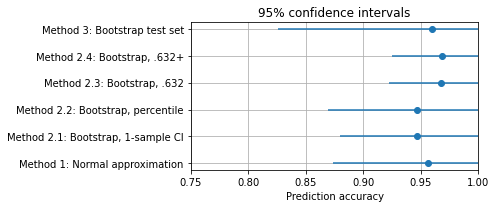

In [29]:
labels = list(results.keys())

means = np.array([results[k]["Test accuracy"] for k in labels])
lower_error = np.array([results[k]["Lower 95% CI"] for k in labels])
upper_error = np.array([results[k]["Upper 95% CI"] for k in labels])

asymmetric_error = [means - lower_error, upper_error - means]


fig, ax = plt.subplots(figsize=(7, 3))
ax.errorbar(means, np.arange(len(means)), xerr=asymmetric_error, fmt="o")
ax.set_xlim([0.75, 1.0])
ax.set_yticks(np.arange(len(means)))
ax.set_yticklabels(labels)
ax.set_xlabel("Prediction accuracy")
ax.set_title("95% confidence intervals")

plt.grid()
plt.tight_layout()
plt.savefig("matplotlib-figures/comparison.pdf")
plt.show()

- We can see that bootstrapping the test set results in the widest confidence intervals, and the .632 estimates results in the smallest confidence intervals. If the .632 confidence intervals are correct (contain the true parameter 95% of the time), then these would be most desirable. 
- However, which confidence interval method is most indeed correct is tricky to answer. There is a quick attempt in the notebook linked in the next section.
- Note that the normal approximation and the bootstrap test set methods have slightly different test accuracy means (dots) because the bootstrap test set one is from averaging the bootstrap test set accuracies; however, we could use the original test set accuracy as the center.

## Confidence Intervals and the True Model Performance

- Have a look at the supplementary [./ci-simulation.ipynb](./ci-simulation.ipynb) notebook for a quick simulation study.

## Bonus: Creating Confidence Intervals with TorchMetrics

- In the context of deep learning and PyTorch, I recently wrote about [TorchMetrics](https://sebastianraschka.com/blog/2022/torchmetrics.html), which is an awesome tool for evaluating models in cases where the dataset is too big to fit into memory.
- We can also use TorchMetrics for bootstrapping. In this case, bootstrapping the test set.
- For comparison, the code for bootstrapping the test set we used earlier was as follows:

In [30]:
clf.fit(X_train, y_train)

predictions_test = clf.predict(X_test)
acc_test = np.mean(predictions_test == y_test)

rng = np.random.RandomState(seed=123)
idx = np.arange(y_test.shape[0])

test_accuracies = []

for i in range(200):

    pred_idx = rng.choice(idx, size=idx.shape[0], replace=True)
    acc_test_boot = np.mean(predictions_test[pred_idx] == y_test[pred_idx])
    test_accuracies.append(acc_test_boot)

bootstrap_train_mean = np.mean(test_accuracies)
bootstrap_train_mean

0.956304347826087

In [31]:
ci_lower = np.percentile(test_accuracies, 2.5)
ci_upper = np.percentile(test_accuracies, 97.5)

print(ci_lower, ci_upper)

0.8695652173913043 1.0


- Using the [`Bootstrapper`](https://torchmetrics.readthedocs.io/en/stable/references/wrappers.html#bootstrapper from TorchMetrics, we can we can replicate the results from above as follows:

In [32]:
import torch
from torchmetrics import Accuracy, BootStrapper

torch.manual_seed(123)

quantiles = torch.tensor([0.05, 0.95])
base_metric = Accuracy()
bootstrap = BootStrapper(
    base_metric, num_bootstraps=200, sampling_strategy="multinomial", quantile=quantiles
)

bootstrap.update(torch.from_numpy(predictions_test), torch.from_numpy(y_test))
output = bootstrap.compute()

print(output)

{'mean': tensor(0.9602), 'std': tensor(0.0408), 'quantile': tensor([0.8696, 1.0000])}


- Note that in practice this can come really handy if we want to compute things incrementally (e.g., if the test set is too big for memory).
- E.g., let's assume the predictions come in multiple chunks:

In [33]:
idx = np.arange(predictions_test.shape[0])
groups = np.array_split(idx, 3)

In [34]:
torch.manual_seed(123)

quantiles = torch.tensor([0.05, 0.95])
base_metric = Accuracy()
bootstrap = BootStrapper(
    base_metric, num_bootstraps=200, sampling_strategy="multinomial", quantile=quantiles
)

for group in groups:

    pred_chunk = torch.from_numpy(predictions_test[group])
    label_chunk = torch.from_numpy(y_test[group])

    bootstrap.update(pred_chunk, label_chunk)

output = bootstrap.compute()
print(output)

{'mean': tensor(0.9550), 'std': tensor(0.0421), 'quantile': tensor([0.8696, 1.0000])}
